In [64]:
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [65]:
df=pd.read_csv('stock_data.csv')


In [68]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749,3486.05


In [69]:
df['Date']=pd.to_datetime(df['Date'],format='%m/%d/%Y')


In [70]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749,3486.05


In [71]:
df.set_index('Date',inplace=True)
df=df.sort_index(ascending=True)

In [72]:
df.head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
Date,,,,,,,
2013-10-08,157.00,157.80,155.20,155.8,155.80,1720413,2688.94
2013-10-09,155.70,158.20,154.15,155.3,155.55,2049580,3204.49
2013-10-10,156.00,160.80,155.85,160.3,160.15,3124853,4978.80
2013-10-11,161.15,163.45,159.00,159.8,160.05,1880046,3030.76
2013-10-14,160.85,161.45,157.70,159.3,159.45,1281419,2039.09


Text(0, 0.5, 'Prices ($)')

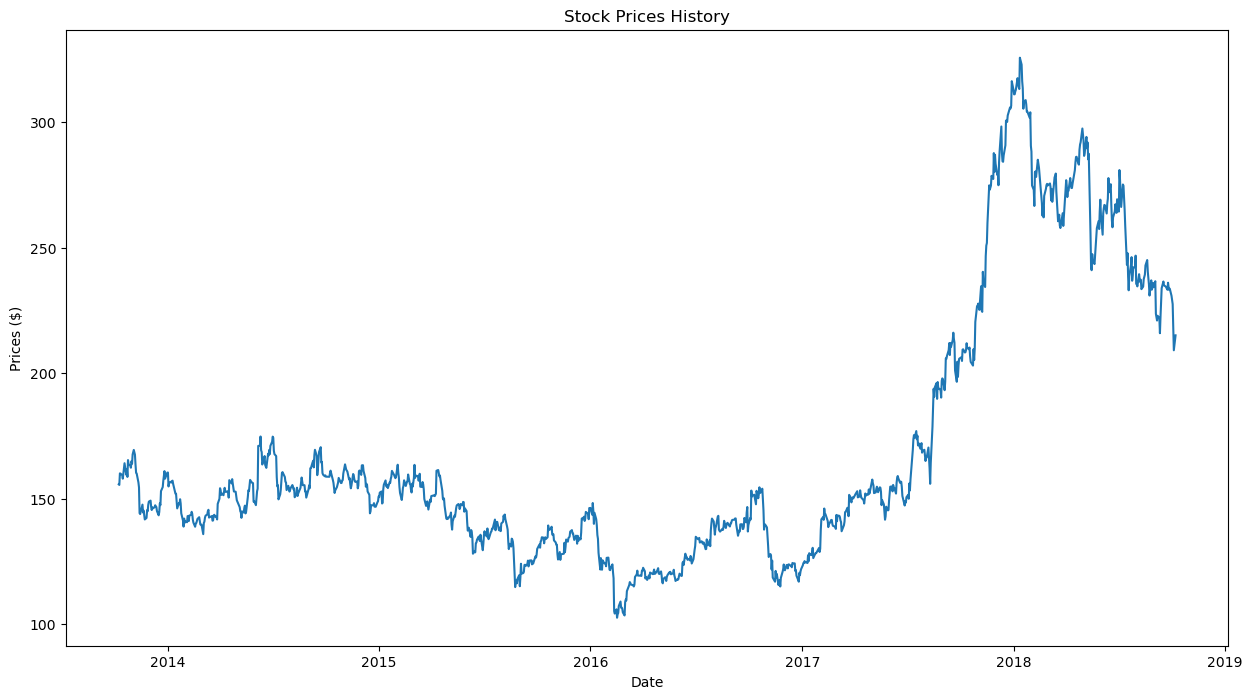

In [73]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [74]:
close_prices = df['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [75]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [76]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 100)           40800     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 26        
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
928/928 [==============================] - 15s 13ms/step - loss: 0.0011
Epoch 2/3
928/928 [==============================] - 12s 13ms/step - loss: 5.1387e-04
Epoch 3/3
928/928 [==============================] - 12s 13ms/step - loss: 3.3954e-04


In [78]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8.241357718402076

C:\Users\harsh\AppData\Local\Temp\ipykernel_30656\3001358295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


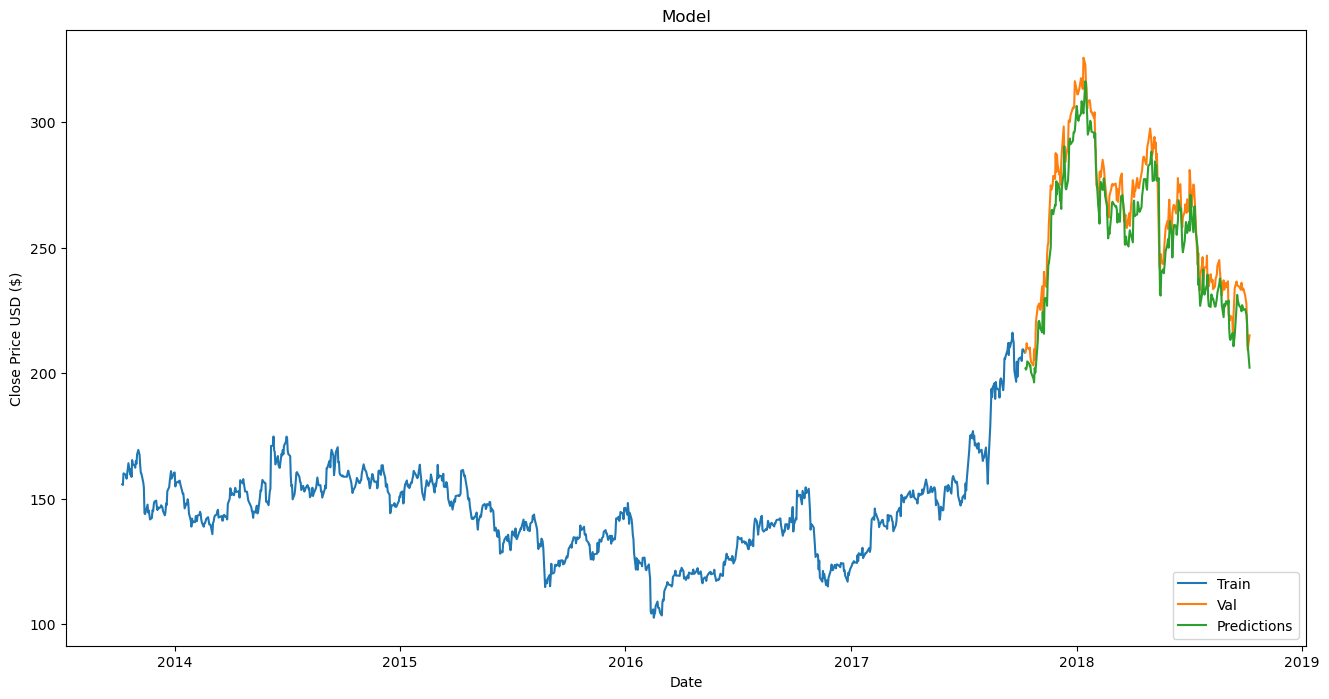

In [79]:
data = df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()